# 多模型分析



In [3]:
# 1 加载数据
import pandas as pd
import matplotlib.pyplot as plt
import os 
base_path = os.path.abspath('.')
print(base_path)

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

/Users/dreamlinx/OneDrive/NetBeansProjects/MyStrategies/backtrader_template


In [4]:
# 定义show df.describe 函数
def show_describe(symbol, period):
    filepath = os.path.join( base_path, 'data', symbol, "{}-{}.csv".format(symbol,period))
    print(filepath)
    df0 = pd.read_csv(filepath)
    df = df0.rename(columns={'Open time': 'date', 'Close time': 'close_time', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    df = df[df['open']!='open']
    
    df.to_csv('_tmp.csv')
    df =pd.read_csv('_tmp.csv')
    # 时间转换成北京时间
    df['date'] = pd.to_datetime(df['date'], unit='ms') + pd.Timedelta(hours=8)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms') + pd.Timedelta(hours=8)

    # 设置index
    df = df.set_index('date', drop=True)
    df.sort_index(inplace=True)
    df['tr'] = df['high'] - df['low']
    df['ptr']= df['tr']/df['open']
    df['pv'] = df['Taker buy base asset volume']/ df['volume']


    return df

In [5]:
symbol = 'BTCUSDT'
period = '5m'

df = show_describe(symbol, period)


/Users/dreamlinx/OneDrive/NetBeansProjects/MyStrategies/backtrader_template/data/BTCUSDT/BTCUSDT-5m.csv


In [127]:
# index > 2023
df = df[df.index > '2023-01-01']
df.head()


,open,high,low,close,volume
date,,,,,
2023-01-01 01:00:00,16600.93,16604.37,16571.01,16582.08,4844.04845
2023-01-01 02:00:00,16581.45,16589.36,16571.80,16577.79,3340.80330
2023-01-01 03:00:00,16577.78,16590.06,16565.10,16570.14,4044.43359
2023-01-01 04:00:00,16570.14,16574.97,16564.09,16568.60,2622.14355
2023-01-01 05:00:00,16568.19,16571.64,16544.12,16548.28,3618.77389


In [129]:
import pandas as pd

# 假设你的数据已经在一个名为df的DataFrame中，其中日期列名为'date'
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')

# 重采样到1小时K线数据
df_resampled = df.resample('4H').agg({'open': 'first', 
                                       'high': 'max', 
                                       'low': 'min', 
                                       'close': 'last', 
                                       'volume': 'sum'})

# 为了避免未来数据的影响，我们需要将数据向前移动一位
df_resampled_shifted = df_resampled.shift(1)
# 获取未来数据
df_resampled_shifted['next_high_1h'] = df_resampled_shifted['high'].shift(-1)

# 将1分钟数据和1小时数据合并
# 注意我们使用了asfreq('1T')来保持数据的索引在分钟级别
df_merged = pd.merge(df, df_resampled_shifted.asfreq('5T'), left_index=True, right_index=True, how='left', suffixes=['_5m', '_1h'])

# 填充NaN值
df_merged.fillna(method='ffill', inplace=True)

# 计算条件
df_merged['condition'] = df_merged['close_5m'] > df_merged['high_1h']

# 打印满足条件的数据
print(df_merged[df_merged['condition']])



                      open_5m   high_5m    low_5m  close_5m   volume_5m  \
date                                                                      
2023-01-01 19:00:00  16547.98  16557.00  16540.20  16556.66  3739.53013   
2023-01-01 20:00:00  16556.66  16572.94  16548.58  16560.93  4150.48564   
2023-01-01 23:00:00  16542.94  16559.99  16533.68  16558.73  3220.93236   
2023-01-02 01:00:00  16565.13  16596.64  16562.51  16578.85  4714.40354   
2023-01-02 02:00:00  16579.25  16603.89  16578.85  16591.88  4146.37245   
...                       ...       ...       ...       ...         ...   
2024-03-31 21:00:00  70500.00  70759.10  70499.99  70585.99  1135.42895   
2024-03-31 22:00:00  70585.99  70680.00  70442.00  70535.48   830.86428   
2024-04-01 02:00:00  70509.11  71227.22  70440.49  70856.60  1636.42274   
2024-04-01 03:00:00  70856.61  71145.97  70647.06  71023.50   948.18598   
2024-04-01 07:00:00  70969.99  71366.00  70923.91  71280.01  1514.23003   

                      op

In [130]:
# 打印满足条件的数据
# print(df_merged[df_merged['condition']])
# df_merged[['close_1m', 'close_1h']].tail()
# 计算收益率
df_merged['return'] = (df_merged['next_high_1h'] - df_merged['close_5m']) / df_merged['close_5m']
df_merged.head(5)

,open_5m,high_5m,low_5m,close_5m,volume_5m,open_1h,high_1h,low_1h,close_1h,volume_1h,next_high_1h,condition,return
date,,,,,,,,,,,,,
2023-01-01 01:00:00,16600.93,16604.37,16571.01,16582.08,4844.04845,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2023-01-01 02:00:00,16581.45,16589.36,16571.80,16577.79,3340.80330,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2023-01-01 03:00:00,16577.78,16590.06,16565.10,16570.14,4044.43359,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2023-01-01 04:00:00,16570.14,16574.97,16564.09,16568.60,2622.14355,16600.93,16604.37,16565.1,16570.14,12229.28534,16574.97,False,0.000384
2023-01-01 05:00:00,16568.19,16571.64,16544.12,16548.28,3618.77389,16600.93,16604.37,16565.1,16570.14,12229.28534,16574.97,False,0.001613


In [131]:
# 定义箱子边界
bins = pd.interval_range(start=-0.05, end=0.05, freq=0.005)

# 对收益进行分箱
df_merged['return_bins'] = pd.cut(df_merged[df_merged['condition']]['return'], bins)

# 对每个箱子进行统计
bin_counts = df_merged['return_bins'].value_counts().sort_index()

# 使用字符串格式化来控制小数的精度
bin_counts.index = bin_counts.index.map(lambda x: f'({x.left:.3f}, {x.right:.3f}]')

# 打印统计结果
print(bin_counts)


return_bins
(-0.050, -0.045]       0
(-0.045, -0.040]       0
(-0.040, -0.035]       0
(-0.035, -0.030]       0
(-0.030, -0.025]       0
(-0.025, -0.020]       0
(-0.020, -0.015]       0
(-0.015, -0.010]       0
(-0.010, -0.005]       0
(-0.005, 0.000]        5
(0.000, 0.005]      1153
(0.005, 0.010]       453
(0.010, 0.015]       139
(0.015, 0.020]        68
(0.020, 0.025]        41
(0.025, 0.030]        12
(0.030, 0.035]         8
(0.035, 0.040]         5
(0.040, 0.045]         2
(0.045, 0.050]         0
Name: count, dtype: int64


In [149]:
df_resampled['tr'] = df_resampled['high'] - df_resampled['low']
df_resampled['ptr'] = df_resampled['tr'] / df_resampled['open']
df_resampled['atr'] = df_resampled['tr'].rolling(window=4).mean()
df_resampled['aptr'] = df_resampled['ptr'].rolling(window=4).mean()
df_resampled[['close', 'ptr', 'aptr','tr']].describe()

,close,ptr,aptr,tr
count,2738.000000,2738.000000,2735.000000,2738.000000
mean,33706.237999,0.013352,0.013358,475.117432
std,12206.254878,0.010822,0.007729,502.923415
min,16526.190000,0.000646,0.001490,17.360000
25%,26408.067500,0.006493,0.008224,187.250000
50%,29161.980000,0.010368,0.011785,328.440000
75%,41017.912500,0.016730,0.016590,583.820000
max,73349.240000,0.119679,0.062131,7991.360000


In [ ]:
# 绘制柱状图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['STIXGeneral']



# 绘制柱状图
bin_counts.plot(kind='bar', figsize=(10, 6))

# 设置标题和标签
plt.title('Return Bins Count')
plt.xlabel('Return Bins')
plt.ylabel('Count')

# 显示图形
plt.show()



# bt回测

In [362]:
import backtrader as bt
symbol = 'BTCUSDT'
periods = [ '1h', '1w']
dfs = {}
for period in periods:
    df = show_describe(symbol, period)
    # columns OHLCV = ['open', 'high', 'low', 'close', 'volume']
    df = df[['open', 'high', 'low', 'close', 'volume']]
    df = df.loc['2022-01-01':'2024-04-30']  # Slice the dataframe
    dfs[period] = df

/Users/dreamlinx/OneDrive/NetBeansProjects/MyStrategies/backtrader_template/data/BTCUSDT/BTCUSDT-1h.csv
/Users/dreamlinx/OneDrive/NetBeansProjects/MyStrategies/backtrader_template/data/BTCUSDT/BTCUSDT-1w.csv


In [368]:
class BaseStrategy(bt.Strategy):
        # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.datetime(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

class MLStrategy(BaseStrategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False,
    )

    def __init__(self):
        # ['1d', '4h', '1h', '30m', '15m']
        self.data5m = self.datas[0]
        self.data1h = self.datas[1]

        self.order = None  # to keep track of pending orders
        self.order_size = 1/10 # 就是动用1/10的资金
        self.limit_price = None
        self.data1h_datetime = None
        
        # 计算5m的atr
        self.atr5m = bt.indicators.ATR(self.data5m, period=14)
        # 1h atr
        self.atr1h = bt.indicators.ATR(self.data1h, period=14)
        # 计算1h的ma
        self.ma1h = bt.indicators.SimpleMovingAverage(self.data1h.close, period=20)
        # 1h macd
        self.macd1h = bt.indicators.MACD(self.data1h.close, period_me1=12, period_me2=24, period_signal=4)

    def next(self):
        # Check if an order is pending
        if self.order:
            return

        size = int(self.broker.getcash() / self.datas[0].open * self.order_size) 
        size = 1
        unrealized_profit = self.broker.getvalue() - self.broker.getcash()
        if self.broker.getcash() < self.data5m.close[0]:
            # 停止交易
            return
        
        for i, d in enumerate(self.datas):
            if 1 == i % 2:
                return
            pos = self.getposition(d)
            last_price =  self.data5m.close[0]
            # 不在场内，则可以买入
            if not len(pos):
                # Check if we are in the market
                pos = self.getposition(data=self.data5m)
                if last_price > self.data1h.high[-1]:
                    # open buy
                    self.log('BUY CREATE, %.2f' % self.data5m.close[0])
                    self.order = self.buy(size=size, data=self.datas[0])
                    self.limit_atr = self.atr1h[-1]
                    self.limit_price = self.data5m.close[0] - self.limit_atr/2
                    # 记录self.data1h当前 id
                    self.data1h_datetime = self.data1h.datetime.datetime(0)
                    return
                
                # if last_price < self.data1h.low[-1]:
                #     # open sell
                #     self.log('SELL CREATE, %.2f' % self.data5m.close[0])
                #     self.order = self.sell(size=size, data=self.datas[0])
                #     self.limit_atr = self.atr1h[-1]
                #     self.limit_price = self.data5m.close[0] + self.limit_atr/2
                #     # 记录self.data1h当前 id
                #     self.data1h_datetime = self.data1h.datetime.datetime(0)
                #     return
            else:
                if pos.size > 0:
                    close_posion = False
                    # 如果 data1h的时间到了下一个，平仓
                    if self.data1h_datetime != self.data1h.datetime.datetime(0):
                        close_posion = True
                    
                    # last price 冲高 atr/2 后回落 atr/4 平仓
                    if (last_price > pos.price + self.limit_atr/2):
                        self.limit_price = pos.price + self.limit_atr/4

                    # 根据atr进行止损
                    if (last_price < self.limit_price):
                        close_posion = True
                    
                    if close_posion:
                        self.log('BUY CLOSE, %.2f' % self.data5m.close[0])
                        self.order = self.sell(size=pos.size, data=self.datas[0])
                        self.limit_price = None
                        
                    return
                        
                if pos.size < 0:
                    close_posion = False
                    # 如果 data1h的时间到了下一个，平仓
                    if self.data1h_datetime != self.data1h.datetime.datetime(0):
                        close_posion = True
                    
                    # last price 冲高 atr/2 后回落 atr/4 平仓
                    if (last_price < pos.price - self.limit_atr/2):
                        self.limit_price = pos.price - self.limit_atr/4
                    
                    # 根据atr进行止损
                    if (last_price > self.limit_price):
                        close_posion = True
                    
                    if close_posion:
                        self.log('SELL CLOSE, %.2f' % self.data5m.close[0])
                        self.order = self.close(size=-pos.size, data=self.datas[0])
                        self.limit_price = None
                    return
                
                
            #     self.order = self.buy(size=self.position.size, data=self.datas[0])    
            # if unrealized_profit < -100:
            #     self.log('SELL CREATE, %.2f' % self.dataclose1[0])
            #     self.order = self.sell(size=self.position.size, data=self.datas[0])
            #     print('Current unrealized profit: %.2f' % (self.broker.getvalue() - self.broker.getcash()))


In [369]:


class MultiTimeframeStrategy(BaseStrategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False,
    )

    def __init__(self):
        self.dataclose1d = self.datas[0].close  # 1 day data
        self.dataclose4h = self.datas[1].close  # 4 hour data
        self.dataclose1h = self.datas[2].close  # 1 hour data
        self.dataclose30m = self.datas[3].close  # 30 min data
        self.dataclose15m = self.datas[4].close  # 15 min data
        self.order = None  # to keep track of pending orders

        # Add Bollinger Bands indicator
        self.bband1d = bt.indicators.BollingerBands(self.datas[0], period=20)
        self.bband4h = bt.indicators.BollingerBands(self.datas[1], period=20)
        self.bband1h = bt.indicators.BollingerBands(self.datas[2], period=20)
        self.bband30m = bt.indicators.BollingerBands(self.datas[3], period=20)
        self.bband15m = bt.indicators.BollingerBands(self.datas[4], period=20)

        # Add MACD indicator
        self.macd1h = bt.indicators.MACDHisto(self.datas[2])
        self.macd30m = bt.indicators.MACDHisto(self.datas[3])
        self.macd15m = bt.indicators.MACDHisto(self.datas[4])
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.datetime(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Check if an order is pending
        if self.order:
            return
        pos = self.getposition(data=self.datas[4])
        # Check if we are in the market
        if  pos.size == 0:
            # We are not in the market, look for a signal to OPEN trades

            # If the 1 day and 4 hour close price crosses above the midline of the Bollinger Bands
            # and the 1 hour, 30 min, 15 min MACD are positive and above the signal line
            if (self.macd15m[-1] > self.bband1d.lines.mid[-1] and
                self.macd15m[-1] > self.bband4h.lines.mid[-1] and
                self.macd1h[-1] > 0 and self.macd1h[-1] > self.macd1h.lines.signal[-1] and
                self.macd30m[-1] > 0 and self.macd30m[-1] > self.macd30m.lines.signal[-1] and
                self.macd15m[0] > 0 and self.macd15m[0] > self.macd15m.lines.signal[0] and
                self.macd15m[-1] < self.macd15m.lines.signal[-1]):
                self.log('BUY CREATE, %.2f' % self.dataclose1h[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(data=self.datas[4])
                self.stop_price = self.bband15m.lines.bot[-1]
                self.limit_price = self.bband30m.lines.top[-1]

        elif pos.size > 0:
            # We are already in the market, look for a signal to CLOSE trades
            if self.dataclose15m[0] < self.stop_price or self.dataclose15m[0] > self.limit_price:
                self.log('SELL CREATE, %.2f' % self.dataclose15m[0])
                self.order = self.sell(data=self.datas[4])
                self.stop_price = None
                self.limit_price = None


In [370]:
class BTCStrategy(BaseStrategy):
    params = dict(
        stop_loss=0.02,  # price is 2% less than the entry point
        trail=False,
    )

    def __init__(self):
        self.data5m = self.datas[0]
        self.data1h = self.datas[1]
        self.orders = []  # to keep track of pending orders

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        for d in self.orders:
            if self.orders[d] == order:
                self.orders[d] = None
                
    def next(self):
        
        for i, d in enumerate(self.datas):
            # Check if an order is pending
            # if self.orders[d]:
            #     continue
            # 如果处理1h线数据则跳过买卖条件，因为已在5m数据判断处理过
            if 1 == i % 2:
                return
            pos = self.getposition(d)
            # 不在场内，则可以买入
            if not len(pos):
                if self.data5m.close[0] > self.data1h.high[0]:
                    self.log('BUY CREATE, %.2f' % self.data5m.close[0])
                    self.buy(data=d, size=1)
            # 在场内，可以卖出
            else:
                if (self.data5m.close[0] < self.data1h.high[-1]-100 or
                        self.data5m.close[0] > self.data1h.high[-1]+100):
                    self.log('SELL CREATE, %.2f' % self.data5m.close[0])
                    self.sell(data=d, size=1)
    

In [371]:
# instantiate SignalData class
import backtrader as bt
import datetime
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=False, runonce=True,preload=True, objcache=True, writer=True)
cerebro.addstrategy(MLStrategy)

for period,df in dfs.items():
    print(period, df.head())
    data = bt.feeds.PandasData(dataname=df)
    
    # data = bt.feeds.PandasData(dataname=df, 
    #     fromdate=datetime.datetime(2023, 1, 1),
    #     todate=datetime.datetime(2023, 3, 31))
    
    cerebro.adddata(data, name=period)
    
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.0005, mult=100)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: {:,.2f}'.format(cerebro.broker.getvalue()))
backtest_result = cerebro.run(cpus=8)
print('Final Portfolio Value: {:,.2f}'.format(cerebro.broker.getvalue()))


1h                          open      high       low     close      volume
date                                                                   
2022-01-01 00:00:00  48005.37  48118.45  47409.77  47471.66  1589.51833
2022-01-01 01:00:00  47471.67  47550.00  46889.00  47016.57  1962.23708
2022-01-01 02:00:00  47016.56  47040.52  46500.00  46686.41  1687.72844
2022-01-01 03:00:00  46686.42  46688.68  45678.96  45728.28  3851.30902
2022-01-01 04:00:00  45728.28  46211.07  45678.00  45879.24  1831.41202
1w                          open      high       low     close         volume
date                                                                      
2022-01-03 08:00:00  47286.18  47570.00  40501.00  41864.62  264331.615870
2022-01-10 08:00:00  41864.62  44500.00  39650.00  43071.66  232059.069690
2022-01-17 08:00:00  43071.66  43505.00  34008.00  36244.55  354513.984320
2022-01-24 08:00:00  36244.55  38919.98  32917.17  37881.76  353702.626391
2022-01-31 08:00:00  37881.75  42656.00 

0.5593434905191946
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SPY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1925-06-22 -> 2024-05-29)')


/Users/dreamlinx/opt/anaconda3/envs/bt/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dreamlinx/opt/anaconda3/envs/bt/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/dreamlinx/opt/anaconda3/envs/bt/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dreamlinx/opt/anaconda3/envs/bt/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/dreamlinx/opt/anaconda3/envs/bt/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dreamlin

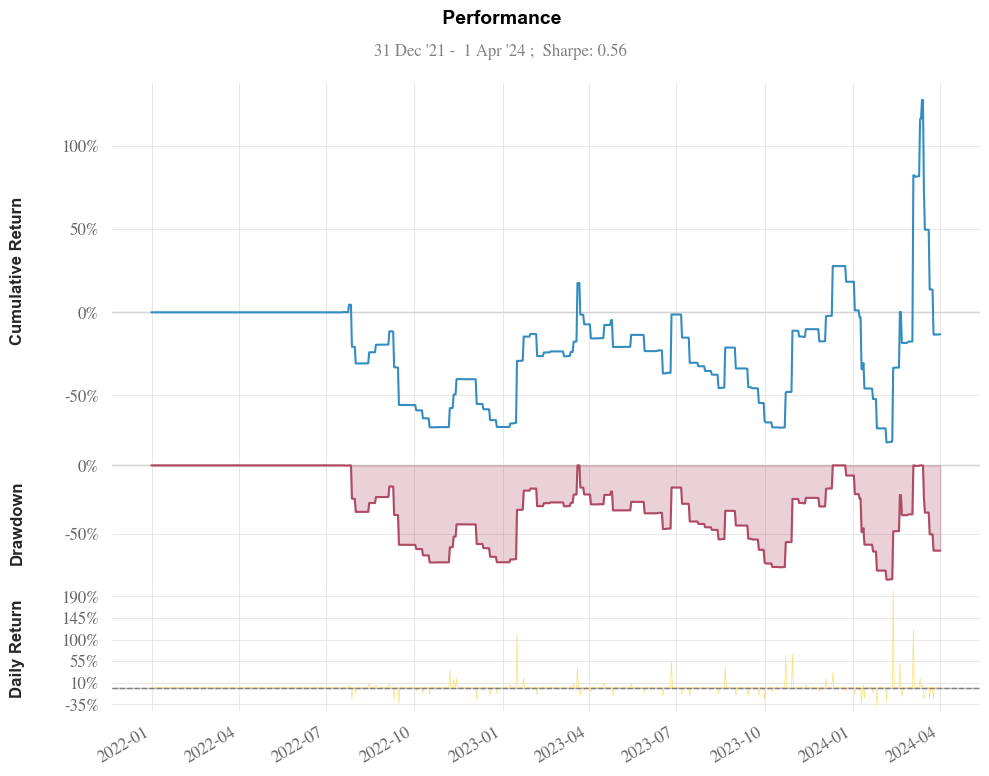

In [372]:
# 绘制柱状图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['STIXGeneral']

strat = backtest_result[0]
    
portfolio_stats = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
import quantstats as qs
print(qs.stats.sharpe(returns))
qs.reports.html(returns, "SPY", output='report.html')

qs.plots.snapshot(returns, title=' Performance')